# Lecture 31–Part 1- Fall 2023



[Acknowledgments Page](https://ds100.org/fa23/acks/)

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In this lecture, we will work with the `vehicles` dataset.

In [2]:
vehicles = sns.load_dataset("mpg").rename(columns={"horsepower":"hp"}).dropna().sort_values("hp")
vehicles.head()

mpg  cylinders  displacement    hp  weight  acceleration  model_year  \
19   26.0          4          97.0  46.0    1835          20.5          70   
102  26.0          4          97.0  46.0    1950          21.0          73   
326  43.4          4          90.0  48.0    2335          23.7          80   
325  44.3          4          90.0  48.0    2085          21.7          80   
244  43.1          4          90.0  48.0    1985          21.5          78   

     origin                             name  
19   europe     volkswagen 1131 deluxe sedan  
102  europe          volkswagen super beetle  
326  europe               vw dasher (diesel)  
325  europe             vw rabbit c (diesel)  
244  europe  volkswagen rabbit custom diesel

Suppose we want to use the `hp` (horsepower) of a car to predict its `mpg` (gas mileage in miles per gallon). If we visualize the relationship between these two variables, we see a non-linear curvature. Fitting a linear model to these variables results in a high (poor) value of RMSE. 

$$\hat{y} = \theta_0 + \theta_1 (\text{hp})$$

RMSE of model with (hp) feature: 4.893226230065712


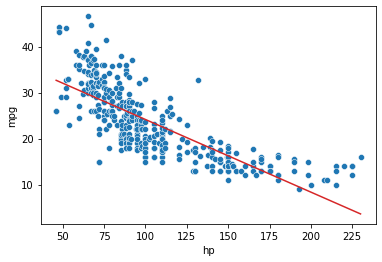

In [3]:
import sklearn.linear_model as lm



X = vehicles[["hp"]]
y = vehicles["mpg"]


hp_model = lm.LinearRegression()
hp_model.fit(X, y)
hp_model_predictions = hp_model.predict(X)

sns.scatterplot(data=vehicles, x="hp", y="mpg")

plt.plot(vehicles["hp"], hp_model_predictions, c="tab:red");

print(f"RMSE of model with (hp) feature: {np.sqrt(np.mean((y-hp_model_predictions)**2))}")

To capture the non-linear relationship between the variables, we can introduce a non-linear feature: `hp` squared. Our new model is:

$$\hat{y} = \theta_0 + \theta_1 (\text{hp}) + \theta_2 (\text{hp}^2)$$

RMSE of model with (hp^2) feature: 4.357151467141951


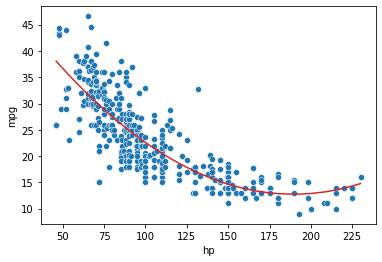

In [4]:
X = vehicles[["hp"]]
X.loc[:, "hp^2"] = vehicles["hp"]**2

hp2_model = lm.LinearRegression()
hp2_model.fit(X, y)
hp2_model_predictions = hp2_model.predict(X)

sns.scatterplot(data=vehicles, x="hp", y="mpg")

plt.plot(vehicles["hp"], hp2_model_predictions, c="tab:red");

print(f"RMSE of model with (hp^2) feature: {np.sqrt(np.mean((y-hp2_model_predictions)**2))}")

What if we take things further and add even *more* polynomial features?


For example, a degree 4 polynomial based on the `hp` feature to predict `mpg` can be characterized as follows:

$$\widehat{mpg} = \theta_0 + \theta_1 hp + \theta_2 hp^2 + \theta_3 hp^3 + \theta_4 hp^4$$

The cell below fits models of increasing complexity and computes their MSEs.

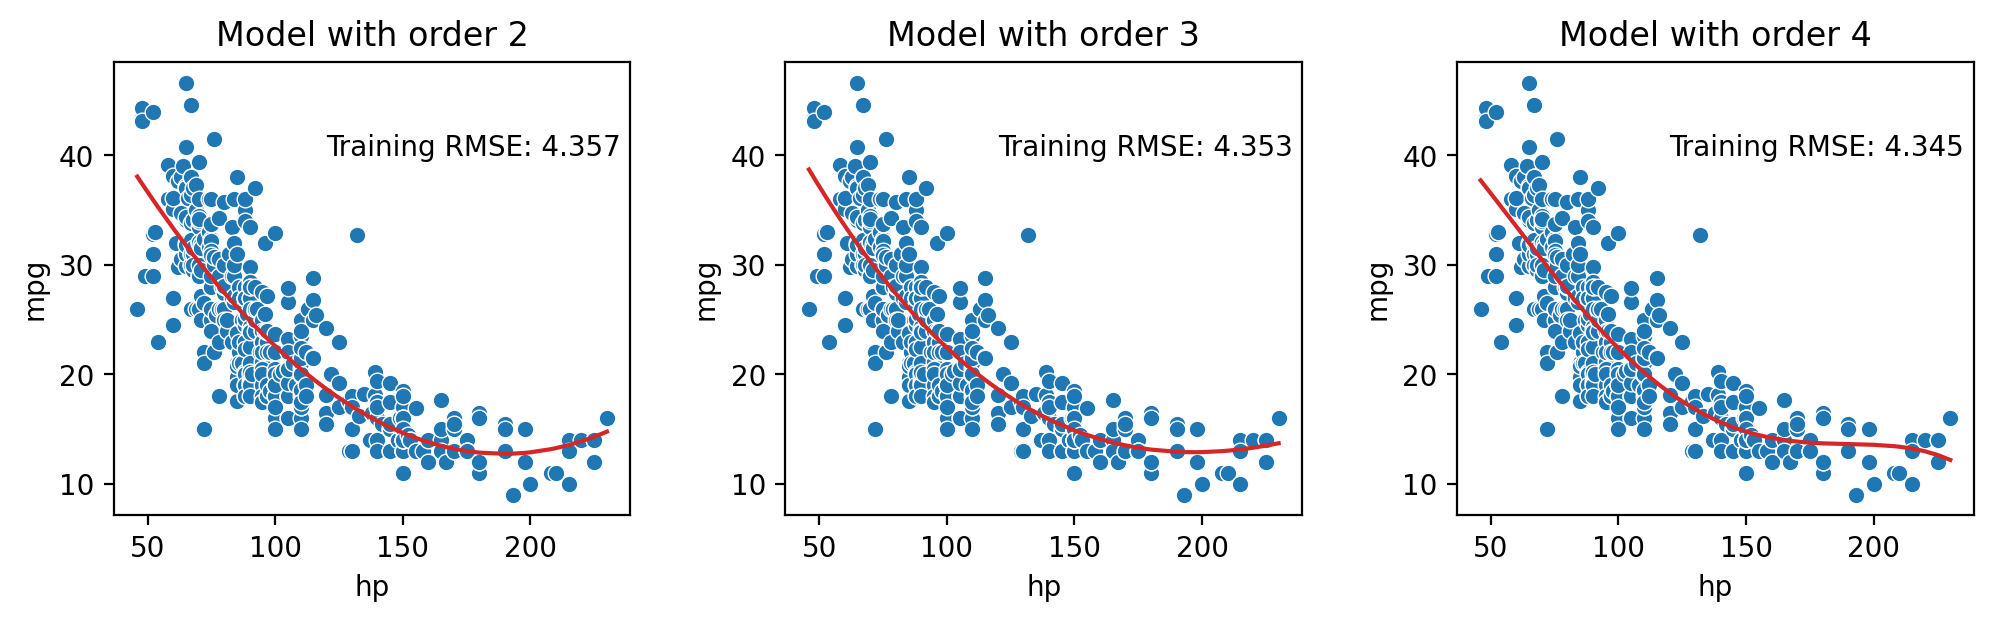

In [5]:
def mse(predictions, observations):
    return np.mean((observations - predictions)**2)

# Add hp^3 and hp^4 as features to the data
X["hp^3"] = vehicles["hp"]**3
X["hp^4"] = vehicles["hp"]**4

# Fit a model with order 3
hp3_model = lm.LinearRegression()
hp3_model.fit(X[["hp", "hp^2", "hp^3"]], vehicles["mpg"])
hp3_model_predictions = hp3_model.predict(X[["hp", "hp^2", "hp^3"]])

# Fit a model with order 4
hp4_model = lm.LinearRegression()
hp4_model.fit(X[["hp", "hp^2", "hp^3", "hp^4"]], vehicles["mpg"])
hp4_model_predictions = hp4_model.predict(X[["hp", "hp^2", "hp^3", "hp^4"]])

# Plot the models' predictions
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

predictions_dict = {0:hp2_model_predictions, 1:hp3_model_predictions, 2:hp4_model_predictions}

for i in predictions_dict:
    ax[i].scatter(vehicles["hp"], vehicles["mpg"], edgecolor="white", lw=0.5)
    ax[i].plot(vehicles["hp"], predictions_dict[i], "tab:red")
    ax[i].set_title(f"Model with order {i+2}")
    ax[i].set_xlabel("hp")
    ax[i].set_ylabel("mpg")
    ax[i].annotate(f"Training RMSE: {np.round(np.sqrt(mse(vehicles['mpg'], predictions_dict[i])), 3)}", (120, 40))

plt.subplots_adjust(wspace=0.3);

## Complexity and Overfitting

What we saw above was the phenomenon of **model complexity** – as we add additional features to the design matrix, the model becomes increasingly *complex*. Models with higher complexity have lower values of training error. Intuitively, this makes sense: with more features at its disposal, the model can match the observations in the trainining data more and more closely. 

We can run an experiment to see this in action. In the cell below, we fit many models of progressively higher complexity, then plot the MSE of predictions on the training set. The code used (specifically, the `Pipeline` and `PolynomialFeatures` functions of `sklearn`) is out of scope.

The **order** of a polynomial model is the highest power of any term in the model. An order 0 model takes the form $\hat{y} = \theta_0$, while an order 4 model takes the form $\hat{y} = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 + \theta_4 x^4$.

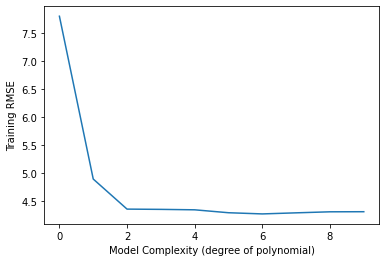

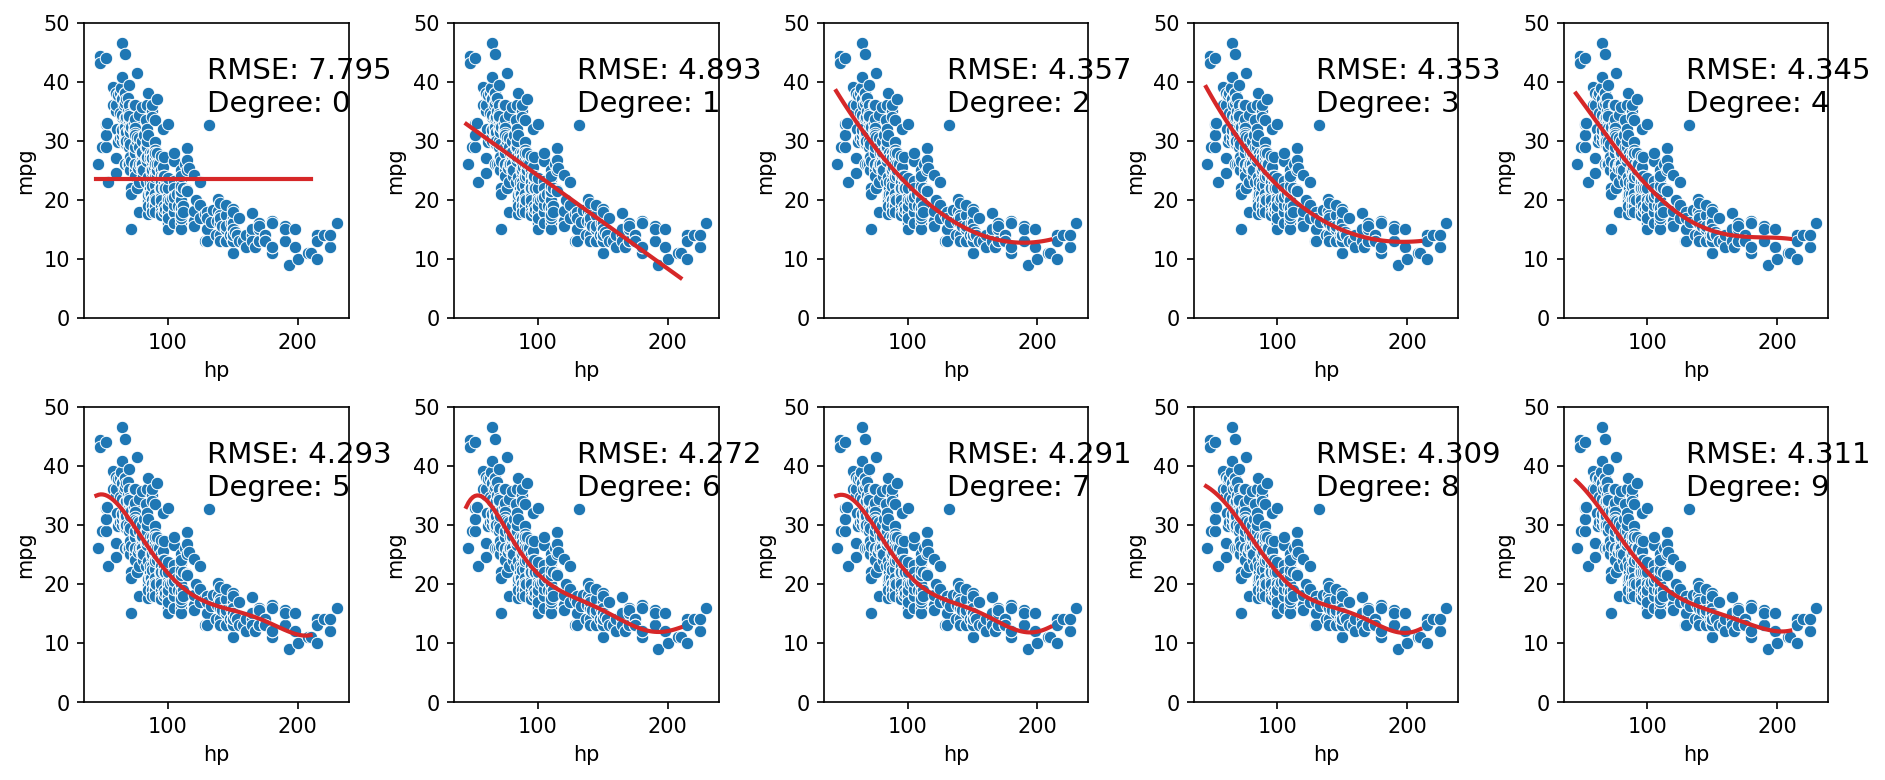

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_model_dataset(degree, dataset):
    pipelined_model = Pipeline([
            ('polynomial_transformation', PolynomialFeatures(degree)),
            ('linear_regression', lm.LinearRegression())    
        ])

    pipelined_model.fit(dataset[["hp"]], dataset["mpg"])
    return np.sqrt(mse(dataset['mpg'], pipelined_model.predict(dataset[["hp"]])))

errors = [fit_model_dataset(degree, vehicles) for degree in range(0, 10)]
RMSEs_and_k = pd.DataFrame({"k": range(0, 10), "RMSE": errors})

plt.plot(range(0, 10), errors)
plt.xlabel("Model Complexity (degree of polynomial)")
plt.ylabel("Training RMSE");

def plot_degree_k_model(k, RMSEs_and_k, axs):
    pipelined_model = Pipeline([
        ('poly_transform', PolynomialFeatures(degree = k)),
        ('regression', lm.LinearRegression(fit_intercept = True))    
    ])
    pipelined_model.fit(vehicles[["hp"]], vehicles["mpg"])
    
    row = k // 5
    col = k % 5
    ax = axs[row, col]
    
    sns.scatterplot(data=vehicles, x='hp', y='mpg', ax=ax)
    
    x_range = np.linspace(45, 210, 100).reshape(-1, 1)
    ax.plot(x_range, pipelined_model.predict(pd.DataFrame(x_range, columns=['hp'])), c='tab:red', linewidth=2)
    
    ax.set_ylim((0, 50))
    mse_str = f"RMSE: {RMSEs_and_k.loc[k, 'RMSE']:.4}\nDegree: {k}"
    ax.text(130, 35, mse_str, dict(size=14))

fig = plt.figure(figsize=(15, 6), dpi=150)
axs = fig.subplots(nrows=2, ncols=5)

for k in range(10):
    plot_degree_k_model(k, RMSEs_and_k, axs)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

As the model increases in polynomial degree (that is, it increases in complexity), the training RMSE decreases, plateauing at roughly ~4.3.

In fact, it is a mathematical fact that if we create a polynomial model with degree $n-1$, we can *perfectly* model a set of $n$ points (assuming all $n$ points describe a function). For example, a set of 5 points can be perfectly modeled by a degree 4 model.

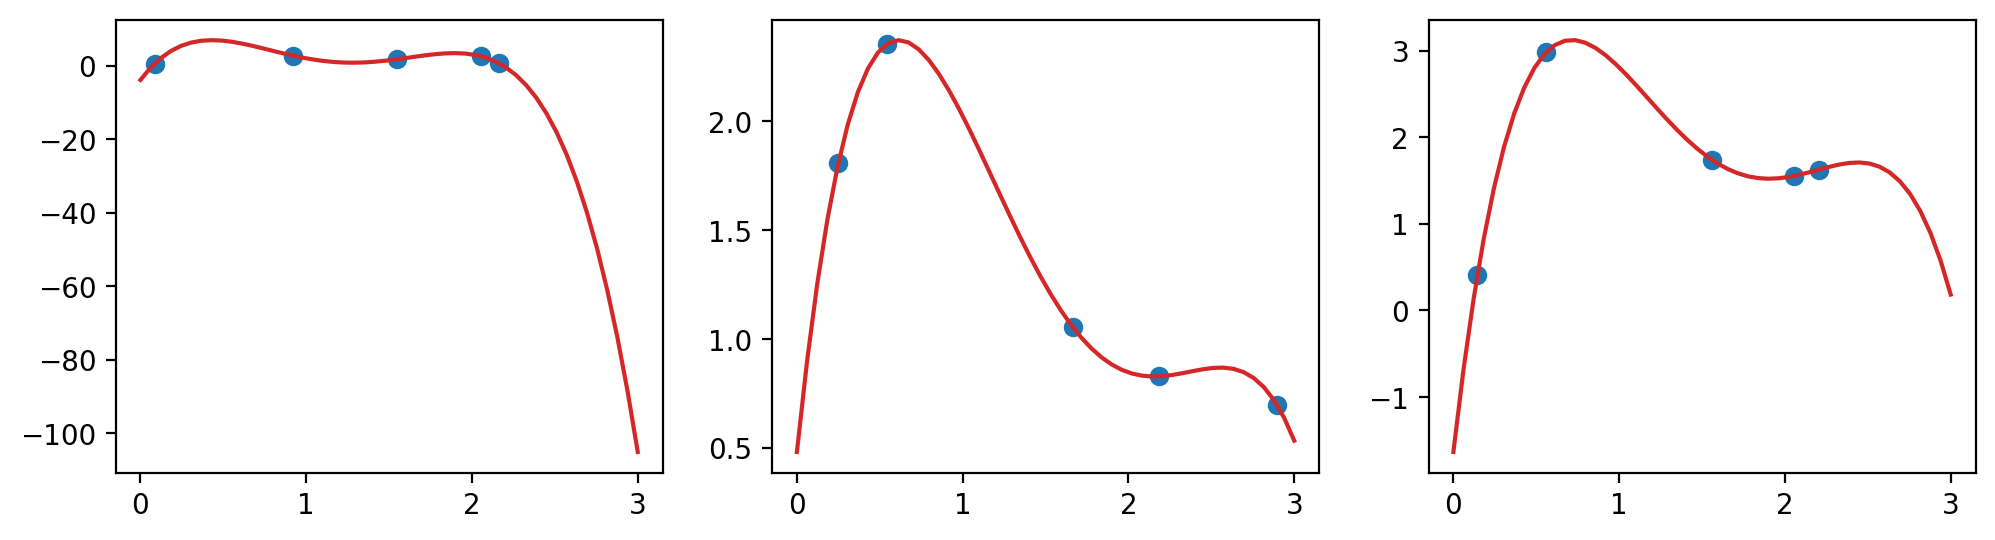

In [7]:
np.random.seed(101)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for i in range(0, 3):
    points = 3*np.random.uniform(size=(5, 2))

    polynomial_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(4)),
                ('linear_regression', lm.LinearRegression())    
            ])

    polynomial_model.fit(points[:, [0]], points[:, 1])

    ax[i].scatter(points[:, 0], points[:, 1])

    xs = np.linspace(0, 3)
    ax[i].plot(xs, polynomial_model.predict(xs[:, np.newaxis]), c="tab:red");

You may be tempted to always design models with high polynomial degree – after all, we know that we could theoretically achieve perfect predictions by creating a model with enough polynomial features. 

It turns out that the examples we looked at above represent a somewhat artificial scenario: we trained our model on all the data we had available, then used the model to make predictions on this very same dataset. A more realistic situation is when we wish to apply our model on unseen data – that is, datapoints that it did not encounter during the model fitting process. 


# Cross Validation

## Train Test Split

The first thing we will want to do with this data is construct a train/test split. Constructing a train test split before EDA and data cleaning can often be helpful.  This allows us to see if our data cleaning and any conclusions we draw from visualizations generalize to new data. This can be done by re-running the data cleaning and EDA process on the test dataset.




### Fitting a Polynomial Function to Predict `mpg`

We select a subset of samples from the `vehicle_data` and we will focus on this sample to build linear regression models with different polynomial degrees from the `hp` feature. For example, a degree 4 polynomial based on the `hp` feature to predict `mpg` can be characterized as follows:

$\widehat{mpg} = \theta_0 + \theta_1 hp + \theta_2 hp^2 + \theta_3 hp^3 + \theta_4 hp^4$



In [8]:
data_use = vehicles[["hp", "mpg"]]

# In general, don't drop values just because they have a duplicate x value - we are doing this to simplify this dataset for the purposes of this example only
data_use=data_use.drop_duplicates(subset=["hp"], keep='first')

In [9]:

# Plotting mpg vs hp to observe the trend in the data
fig = px.scatter(data_use, x="hp", y="mpg")
fig.show()

### Using Pandas Operations

We can sample the entire dataset to get a permutation and then select a range of rows.

In [10]:


data_use["hp^2"] = vehicles["hp"]**2
data_use["hp^3"] = vehicles["hp"]**3
data_use["hp^4"] = vehicles["hp"]**4

data_use.head()

X = data_use[["hp", "hp^2", "hp^3", "hp^4"]]


Y = data_use["mpg"]


shuffled_data = data_use.sample(frac=1., random_state=42)
shuffled_data

hp   mpg     hp^2       hp^3         hp^4
110   94.0  22.0   8836.0   830584.0   78074896.0
52    76.0  30.0   5776.0   438976.0   33362176.0
361  116.0  25.4  13456.0  1560896.0  181063936.0
292  150.0  18.5  22500.0  3375000.0  506250000.0
19    46.0  26.0   2116.0    97336.0    4477456.0
..     ...   ...      ...        ...          ...
375   74.0  36.0   5476.0   405224.0   29986576.0
0    130.0  18.0  16900.0  2197000.0  285610000.0
232  149.0  16.0  22201.0  3307949.0  492884401.0
239   67.0  30.0   4489.0   300763.0   20151121.0
341  110.0  23.5  12100.0  1331000.0  146410000.0

[93 rows x 5 columns]

Selecting a range of rows for training and test

In [11]:
split_point = int(shuffled_data.shape[0]*0.80)
split_point

74

In [12]:
tr = shuffled_data.iloc[:split_point]
te = shuffled_data.iloc[split_point:]

In [13]:
display(tr.head())
len(tr)

hp   mpg     hp^2       hp^3         hp^4
110   94.0  22.0   8836.0   830584.0   78074896.0
52    76.0  30.0   5776.0   438976.0   33362176.0
361  116.0  25.4  13456.0  1560896.0  181063936.0
292  150.0  18.5  22500.0  3375000.0  506250000.0
19    46.0  26.0   2116.0    97336.0    4477456.0

74

In [14]:
display(te.head())
len(te)

hp   mpg     hp^2       hp^3         hp^4
166  129.0  13.0  16641.0  2146689.0  276922881.0
288  135.0  18.2  18225.0  2460375.0  332150625.0
104  167.0  12.0  27889.0  4657463.0  777796321.0
119   91.0  20.0   8281.0   753571.0   68574961.0
238   83.0  33.5   6889.0   571787.0   47458321.0

19

Checking that they add up.

In [15]:
len(tr) + len(te) == len(data_use)

True

### Using SKLearn

We can use the `train_test_split` function from `sklearn.model_selection` to do this easily.

In [16]:

from sklearn.model_selection import train_test_split

# `test_size` specifies the proportion of the full dataset that should be allocated to testing.
# `random_state` makes our results reproducible for educational purposes.
# shuffle is True by default and randomizes the data before splitting.



X = data_use[["hp", "hp^2", "hp^3", "hp^4"]]


Y = data_use["mpg"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=100, 
                                                    shuffle=True)

print(f"Size of full dataset: {X.shape[0]} points")
print(f"Size of training set: {X_train.shape[0]} points")
print(f"Size of test set: {X_test.shape[0]} points")


Size of full dataset: 93 points
Size of training set: 74 points
Size of test set: 19 points


We then fit the model using the training set...

In [17]:
import sklearn.linear_model as lm

model = lm.LinearRegression()

model.fit(X_train, Y_train)

from sklearn.metrics import mean_squared_error

train_error = np.sqrt(mean_squared_error(Y_train, model.predict(X_train)))

print(f"Training error (RMSE): {train_error}")

Training error (RMSE): 4.283501961446063



### Don't try this at home! 

The test error is:

In [18]:

test_error = np.sqrt(mean_squared_error(Y_test, model.predict(X_test)))


print(f"Test error (RMSE): {test_error}")

Test error (RMSE): 4.171592165190313


Oh no! We just used the test data to evaluate our model! We shouldn't have done that.  

(Don't worry, we are trained professionals and this is only for demonstration purposes.  But seriously, don't try this at home.)  

**Notice:** The test error is slightly higher than the training error.  This is typically (but not always) the case.  Sometimes we get lucky and the test data is "easier to predict" or happens to closely follow the training data.

## Validation Sets

To assess model performance on unseen data, then *use* this information to finetune the model, we introduce a validation set. You can imagine this as us splitting the training set into a validation set and a "mini" training set.

In [19]:
# Split X_train further into X_train_mini and X_val.
X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=100)

print(f"Size of original training set: {X_train.shape[0]} points")
print(f"Size of mini training set: {X_train_mini.shape[0]} points")
print(f"Size of validation set: {X_val.shape[0]} points")

Size of original training set: 74 points
Size of mini training set: 59 points
Size of validation set: 15 points


In the cell below, we fit several models of increasing complexity, then compute their errors. Here, we find the model's errors on the **validation set** to understand how model complexity influences performance on unseen data.

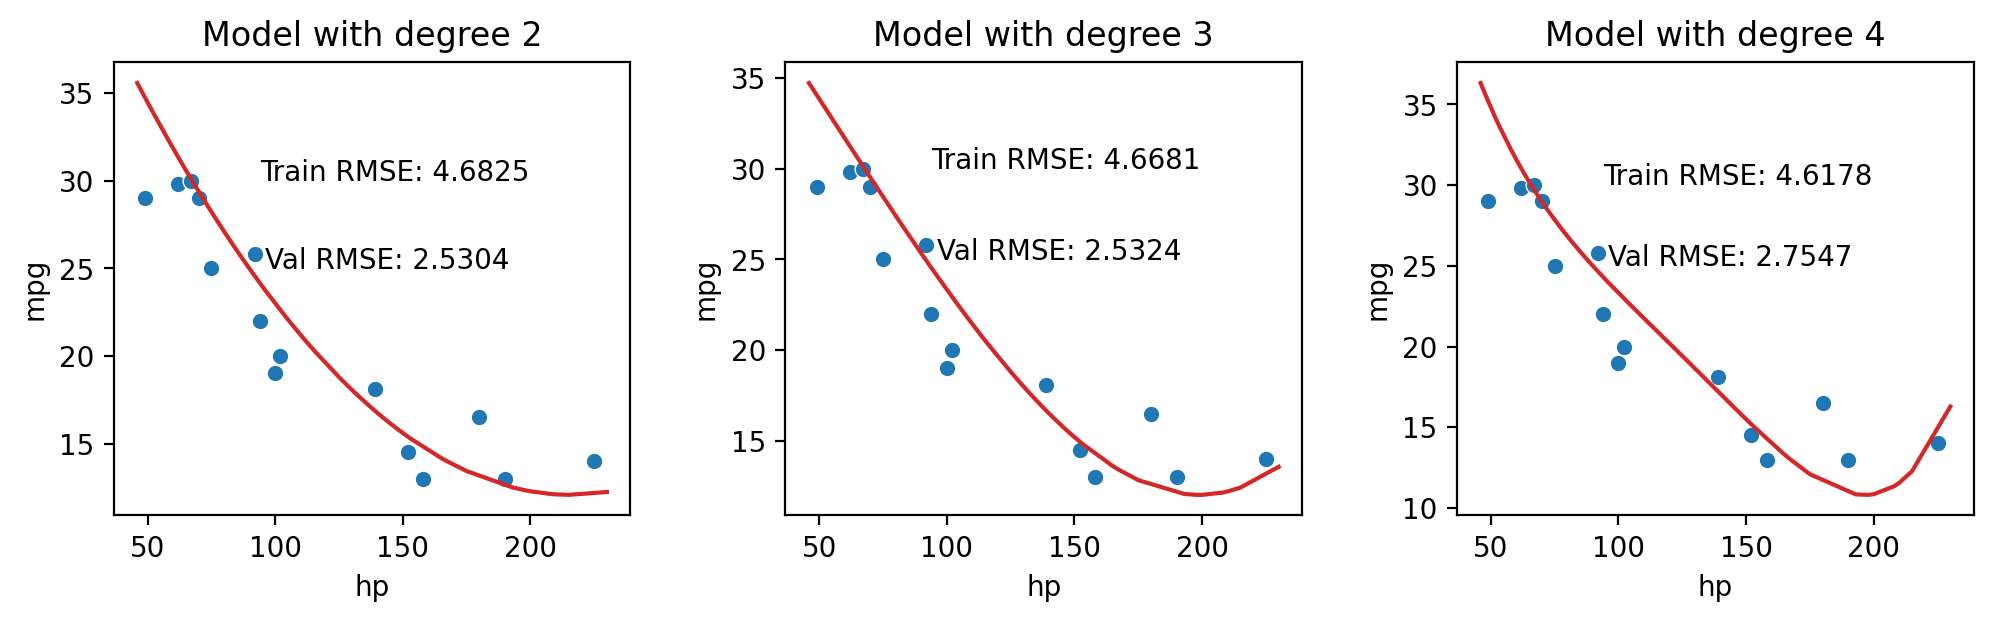

In [20]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for order in [2, 3, 4]:
    model = lm.LinearRegression()
    model.fit(X_train_mini.iloc[:, :order], Y_train_mini)
    val_predictions = model.predict(X_val.iloc[:, :order])
    train_predictions=model.predict(X_train_mini.iloc[:, :order])
    
    output = X_val.iloc[:, :order]
    output["y_hat"] = val_predictions
    output = output.sort_values("hp")
    
    
    output_t = X_train_mini.iloc[:, :order]
    output_t["y_hat"] = train_predictions
    output_t = output_t.sort_values("hp")
    
    ax[order-2].scatter(X_val["hp"], Y_val, edgecolor="white", lw=0.5)
    ax[order-2].plot(output_t["hp"], output_t["y_hat"], "tab:red")
    ax[order-2].set_title(f"Model with degree {order}")
    ax[order-2].set_xlabel("hp")
    ax[order-2].set_ylabel("mpg")
    ax[order-2].annotate(f"Train RMSE: {np.round(np.sqrt(mean_squared_error(Y_train_mini, train_predictions)), 4)}", (94, 30))
    ax[order-2].annotate(f"Val RMSE: {np.round(np.sqrt(mean_squared_error(Y_val, val_predictions)), 4)}", (96, 25))

plt.subplots_adjust(wspace=0.3);

Let's repeat this process:

1. Fit an degree-x model to the mini training set
2. Evaluate the fitted model's RMSE when making predictions on the validation set

We use the model's performance on the validation set as a guide to selecting the best combination of features. We are not limited in the number of times we use the validation set – we just never use this set to fit the model.


The code below uses `Pipelines` in scikit-learn.  For the scope of CSCI 3022 this semester, you do not need to know how to use sci-kit learn's `Pipeline` class - it is quite involved. Fortunately, they are merely an accessory to the concepts of this lecture, and not the core of it. If you treat each instance of a `Pipeline` as a black-box way of specifying which features our model should have, you will be able to understand the cross-validation content just fine.

If you're interested, you can [skim the documentation on pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline).


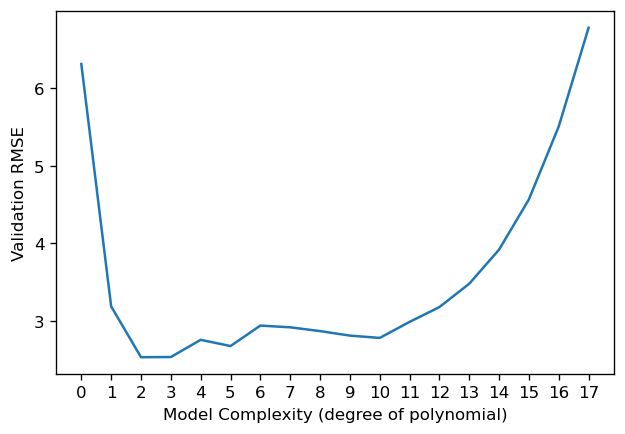

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_model_dataset(degree):
    pipelined_model = Pipeline([
            ('polynomial_transformation', PolynomialFeatures(degree)),
            ('linear_regression', lm.LinearRegression())    
        ])

    pipelined_model.fit(X_train_mini[["hp"]], Y_train_mini)
    return np.sqrt(mean_squared_error(Y_val, pipelined_model.predict(X_val[["hp"]])))

errors = [fit_model_dataset(degree) for degree in range(0, 18)]
RMSEs_and_k = pd.DataFrame({"k": range(0, 18), "Validation RMSE": errors})

plt.figure(dpi=120)
plt.plot(range(0, 18), errors)
plt.xlabel("Model Complexity (degree of polynomial)")
plt.ylabel("Validation RMSE")
plt.xticks(range(0, 18));

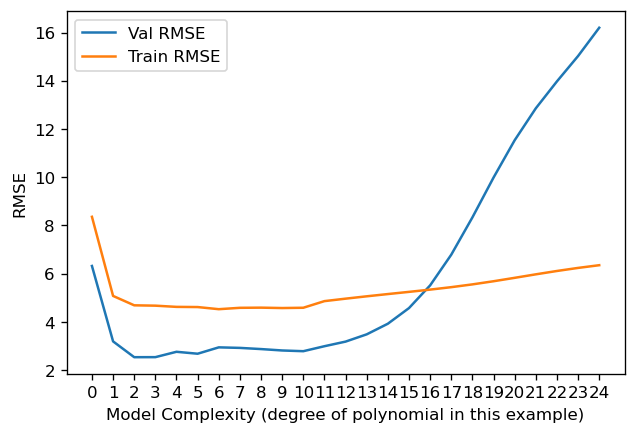

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def fit_model_dataset(degree):
    pipelined_model = Pipeline([
            ('polynomial_transformation', PolynomialFeatures(degree)),
            ('linear_regression', lm.LinearRegression())    
        ])

    pipelined_model.fit(X_train_mini[["hp"]], Y_train_mini)
    training_error = np.sqrt(mean_squared_error(pipelined_model.predict(X_train_mini[["hp"]]), Y_train_mini))
    validation_error = np.sqrt(mean_squared_error(pipelined_model.predict(X_val[["hp"]]), Y_val))
    return [degree, training_error, validation_error]
    
    
    
ks = np.array(range(0, 25))
RMSEs = [fit_model_dataset(k) for k in ks]
RMSEs_and_k = pd.DataFrame(RMSEs, columns = ['Degree', 'Training RMSE', 'Validation RMSE'])
RMSEs_and_k
    



plt.figure(dpi=120)
plt.plot(RMSEs_and_k["Degree"], RMSEs_and_k["Validation RMSE"], label="Val RMSE")
plt.plot(RMSEs_and_k["Degree"], RMSEs_and_k["Training RMSE"], label = "Train RMSE")
plt.xlabel("Model Complexity (degree of polynomial in this example)")
plt.ylabel("RMSE")
plt.xticks(range(0, 25));
plt.legend()




In [23]:
RMSEs_and_k.rename(columns={"k":"Degree"}).set_index("Degree")

Training RMSE  Validation RMSE
Degree                                
0            8.354251         6.315041
1            5.071838         3.185879
2            4.682550         2.530384
3            4.668125         2.532364
4            4.617849         2.754715
5            4.610463         2.674350
6            4.521797         2.938491
7            4.578939         2.916222
8            4.585646         2.867303
9            4.569502         2.809041
10           4.581465         2.779103
11           4.856434         2.985910
12           4.958535         3.177239
13           5.056199         3.478455
14           5.149289         3.918986
15           5.240365         4.567915
16           5.333947         5.509114
17           5.435729         6.783101
18           5.550859         8.329364
19           5.681146         9.982392
20           5.822900        11.530989
21           5.967869        12.855562
22           6.107055        13.972478
23           6.234183        15.024882
24           6.346635        16.197836

From this **model selection** process, we might choose to create a model with degree 2 (it gives the lowest validation RMSE)

After this choice has been finalized, and we are completely finished with the model design process, we finally assess model performance on the test set. We typically use the entire training set (both the "mini" training set and validation set) to fit the final model.

In [24]:
display(X_train.head())


display(X_test.head())


hp     hp^2       hp^3          hp^4
27   210.0  44100.0  9261000.0  1.944810e+09
375   74.0   5476.0   405224.0  2.998658e+07
297   77.0   5929.0   456533.0  3.515304e+07
218   58.0   3364.0   195112.0  1.131650e+07
195   52.0   2704.0   140608.0  7.311616e+06

hp     hp^2       hp^3         hp^4
69   160.0  25600.0  4096000.0  655360000.0
288  135.0  18225.0  2460375.0  332150625.0
296   80.0   6400.0   512000.0   40960000.0
238   83.0   6889.0   571787.0   47458321.0
82    97.0   9409.0   912673.0   88529281.0

## Final Step:  After we've selected order of Model Use our Test Set Once to Calculate Test RMSE

In [25]:
# Once we've used the validation set to determine the highest order of the polynomial, we can create our FINAL model using all of the training data

X_train=X_train.drop(columns=["hp^3", "hp^4"])
X_test = X_test.drop(columns=["hp^3", "hp^4"])

final_model = lm.LinearRegression()
final_model.fit(X_train, Y_train)


print(f"Test RMSE of final model: {np.sqrt(mean_squared_error(Y_test, final_model.predict(X_test)))}")



Test RMSE of final model: 4.131936591103031


## A more complete process: Cross-Validation

The validation set gave us an opportunity to understand how the model performs on a **single** set of unseen data. The specific validation set we drew was fixed – we used the same validation points every time.

It's possible that we may have, by random chance, selected a set of validation points that was *not* representative of other unseen data that the model might encounter (for example, if we happened to have selected all outlying data points for the validation set).

Different train/validation splits lead to different validation errors:

In [26]:
for i in range(1, 4):
    X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
    model = lm.LinearRegression()
    model.fit(X_train_mini, Y_train_mini)
    y_hat = model.predict(X_val)
    print(f"Val error from train/validation split #{i}: {np.sqrt(mean_squared_error(y_hat, Y_val))}")

Val error from train/validation split #1: 3.9658557829143213
Val error from train/validation split #2: 2.788416784702916
Val error from train/validation split #3: 4.897510354516004


To apply cross-validation, we use the `KFold` class of `sklearn.model_selection`. `KFold` will return the indices of each cross-validation fold. Then, we iterate over each of these folds to designate it as the validation set, while training the model on the remaining folds.

In [27]:
from sklearn.model_selection import KFold
np.random.seed(25) # Ensures reproducibility of this notebook


# n_splits sets the number of folds to create
kf = KFold(n_splits=5, shuffle=True)
validation_errors = []

for train_idx, valid_idx in kf.split(X_train):
    # Split the data
    split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

    # Fit the model on the training split
    model.fit(split_X_train, split_Y_train)

    error = np.sqrt(mean_squared_error(model.predict(split_X_valid), split_Y_valid))

    validation_errors.append(error)
    
    
print(validation_errors)
print(f"Cross-validation error (RMSE) for 2nd order model: {np.mean(validation_errors)}")

[5.164983857200765, 4.944603692336901, 3.3398270026958423, 4.007089787002329, 4.43414356164279]
Cross-validation error (RMSE) for 2nd order model: 4.378129580175726


## Let's do cross validation for each of the orders (up to order 6):

In [28]:
from sklearn.model_selection import KFold
np.random.seed(25)

def train_with_crossvalidation(degree, folds):
    kf = KFold(n_splits=folds, shuffle=True)
    validation_errors = []

    X = X_train[["hp"]] 
    Y = Y_train
    model = Pipeline([
        ('transform', PolynomialFeatures(degree = degree)),
        ('regression', LinearRegression(fit_intercept = True))    
    ])
    for train_idx, valid_idx in kf.split(X):
        # Split the data
        split_X_train, split_X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y.iloc[train_idx], Y.iloc[valid_idx]
      
        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        error = np.sqrt(mean_squared_error(model.predict(split_X_valid), split_Y_valid))

        validation_errors.append(error)
    return np.mean(validation_errors)

In [39]:
np.random.seed(25)
ks = np.array(range(0, 7))
folds = np.array(range(2, 6))
RMSEs_CV = pd.DataFrame(columns = ['k', 'folds', 'Ave RMSE'])
for k in ks:
    for f in folds:
        RMSEs_CV = RMSEs_CV.append({'k': k, 'folds': f, 'Ave RMSE': train_with_crossvalidation(k, f)}, 
                       ignore_index=True)

RMSEs_CV['k'] = RMSEs_CV['k'].astype('int')
RMSEs_CV['folds'] = RMSEs_CV['folds'].astype('int')

RMSEs_CV

k  folds  Ave RMSE
0   0      2  8.049242
1   0      3  7.951866
2   0      4   7.98125
3   0      5  8.142638
4   1      2  4.730237
5   1      3  4.730506
6   1      4  4.888296
7   1      5  4.692053
8   2      2  4.448725
9   2      3  4.432698
10  2      4  4.117609
11  2      5   4.39764
12  3      2  5.062636
13  3      3  4.974356
14  3      4  4.436635
15  3      5  4.509117
16  4      2  4.901588
17  4      3  4.507878
18  4      4  4.893893
19  4      5  4.265409
20  5      2   4.75908
21  5      3  4.716919
22  5      4  5.066458
23  5      5  4.688384
24  6      2   4.47891
25  6      3  4.758193
26  6      4  4.563723
27  6      5  4.655074

In [41]:
RMSEs_CV[RMSEs_CV["folds"]==5]

k  folds  Ave RMSE
3   0      5  8.142638
7   1      5  4.692053
11  2      5   4.39764
15  3      5  4.509117
19  4      5  4.265409
23  5      5  4.688384
27  6      5  4.655074

In [30]:
# Looking into RMSEs for different degree polynomials
RMSEs_CV.groupby("k")["Ave RMSE"].mean().to_frame()

Ave RMSE
k          
0  7.994119
1  4.987893
2  4.490298
3  4.575489
4  5.016895
5  4.875543
6  4.981169

## Conclusion, again, this k-fold cross validation confirms that for this dataset, we would choose a 2nd order model

## Code to Supplement Appendix:  Regularization (Not in Scope for CSCI 3022, but useful information when building real models)

### L1 (LASSO) Regularization

To apply L1 regularization, we use the `Lasso` model class of `sklearn`. `Lasso` functions just like `LinearRegression`. The difference is that now the model will apply a *regularization penalty*. We specify the strength of regularization using the `alpha` parameter, which is equivalent to $\frac{1}{\lambda}$ from our objective function formulation.

In [31]:
import sklearn.linear_model as lm

lasso_model = lm.Lasso(alpha=0.1) # In sklearn, alpha represents the lambda hyperparameter
lasso_model.fit(X_train, Y_train) 

lasso_model.coef_

array([-0.34302151,  0.00080563])

To increase the strength of regularization (decrease model complexity), we increase the $\lambda$ hyperparameter by changing `alpha`.

In [32]:
lasso_model_large_lambda = lm.Lasso(alpha=10)
lasso_model_large_lambda.fit(X_train, Y_train) 

lasso_model_large_lambda.coef_

array([-0.22076061,  0.00035323])

Notice that these model coefficients are very small (some are effectively 0). This reflects L1 regularization's tendency to set the parameters of unimportant features to 0. We can use this in **feature selection**.

The features in our dataset are on wildly different numerical scales. To see this, compare the values of `hp` to the values of `hp^8`.

In [33]:
X_train.head()

hp     hp^2
27   210.0  44100.0
375   74.0   5476.0
297   77.0   5929.0
218   58.0   3364.0
195   52.0   2704.0

In order for the feature `hp` to contribute in any meaningful way to the model, LASSO is "forced" to allocate disproportionately much of its parameter "budget" towards assigning a large value to the model parameter for `hp`. Notice how the parameter for `hp` is much, much greater in magnitude than the parameter for `hp^8`.

In [34]:
pd.DataFrame({"Feature":X_train.columns, "Parameter":lasso_model.coef_})

Feature  Parameter
0      hp  -0.343022
1    hp^2   0.000806

We typically **scale** data before regularization such that all features are measured on the same numeric scale. One way to do this is by **standardizing** the data such that it has mean 0 and standard deviation 1.

In [35]:
# Center the data to have mean 0
X_train_centered = X_train - X_train.mean() 

# Scale the centered data to have SD 1
X_train_standardized = X_train_centered/X_train_centered.std()

X_train_standardized.head()

hp      hp^2
27   1.964873  2.220004
375 -0.830897 -0.770355
297 -0.769226 -0.735283
218 -1.159811 -0.933871
195 -1.283154 -0.984970

When we re-fit a LASSO model, the coefficients are no longer as uneven in magnitude as they were before.

In [36]:
lasso_model_scaled = lm.Lasso(alpha=0.1)
lasso_model_scaled.fit(X_train_standardized, Y_train)
lasso_model_scaled.coef_

array([-10.97271826,   4.69153147])

### L2 (Ridge) Regression

We perform ridge regression using `sklearn`'s `Ridge` class.

In [37]:
ridge_model = lm.Ridge(alpha=0.1)
ridge_model.fit(X_train_standardized, Y_train)

ridge_model.coef_

array([-15.76512555,   9.48775512])